In [83]:
import numpy as np
import pickle
import sys
import os
from scipy import stats as spstats
from scipy.spatial import procrustes

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

sys.path.append("../dsc/functions")
from fit_truncated_svd import truncated_svd
from fit_lowrank import rpca, nnm, nnm_sparse
from fit_factorgo import FactorGoCLI

sys.path.append("/gpfs/commons/home/sbanerjee/work/npd/npd-notes/notebooks/utils/")
import histogram as mpy_histogram
import plot_functions as mpy_plotfn

In [68]:
def distribute_samples_to_classes(Q, n, shuffle = False):
    '''
    Distribute n samples to Q classes
    '''
    rs = 0.6 * np.random.rand(Q) + 0.2 # random sample from [0.2, 0.8)
    z = np.array(np.round((rs / np.sum(rs)) * n), dtype = int)
    z[-1] = n - np.sum(z[:-1])
    tidx = np.arange(n)
    if shuffle:
        np.random.shuffle(tidx)
    bins = np.zeros(Q + 1, dtype = int)
    bins[1:] = np.cumsum(z)
    idx_groups  = [np.sort(tidx[bins[i]:bins[i+1]]) for i in range(Q)]
    labels = [i for idx in range(n) for i in range(Q) if idx in idx_groups[i]]
    return idx_groups, labels



def get_blockdiag_matrix(n, rholist, rhobg, idx_groups):
    '''
    Generate a block diagonal matrix of size n x n.
    S_ij = 1, if i = j
         = rholist[q],  if i,j \in idx_groups[q]
         = rhobg, otherwise
    '''
    R = np.ones((n, n)) * rhobg

    for i, (idx, rho) in enumerate(zip(idx_groups, rholist)):
        nblock = idx.shape[0]
        xblock = np.ones((nblock, nblock)) * rho 
        R[np.ix_(idx, idx)] = xblock

    R[np.diag_indices_from(R)] = 1.0 

    return R

def simulate_effect_size(n, p, k, Q, h2, g2, 
        aq, a0, nsample,
        corr_base = 1.0,
        cov_design = 'blockdiag',
        sharing_proportion = 0.2,
        shuffle = False,
        seed = None):
    ''' 
    Get Y = LF' + M + E  where columns of F are orthonormal,
    and L is a blockdiagonal matrix.
    LF' correspond to the shared component of effect sizes,
    the distinct components are given by M, which is sampled
    from a Laplace distribution.
    The noise in the estimate of the effect sizes is given by E.
    '''
    if seed is not None: np.random.seed(seed)
    if not isinstance(h2, np.ndarray):
        h2 = np.ones(n) * h2
    if not isinstance(g2, np.ndarray):
        g2 = np.ones(n) * g2
    if not isinstance(nsample, np.ndarray):
        nsample = np.ones(n) * nsample
    # number of shared and distinct components
    p_shared = int(p * sharing_proportion)
    p_distinct = p - p_shared
    # a_q and a_0
    #a0 = corr_base / (1 + aq_ratio)
    #aq = aq_ratio * a0

    C_ixgrp, C = distribute_samples_to_classes(Q, n, shuffle = shuffle)
    ggT  = np.sqrt(np.einsum('i,j->ij', g2, g2))
    if cov_design == 'blockdiag':
        rho  = [aq for _ in range(Q)]
        covL = get_blockdiag_matrix(n, rho, a0, C_ixgrp) * ggT
    else:
        covL = np.eye(n) * ggT
    # normalize L for correct variance.
    L  = np.random.multivariate_normal(np.zeros(n), covL, size = k).T
    L /= np.sqrt(k)
    #F  = spstats.ortho_group.rvs(p)[:, :k]
    F  = spstats.ortho_group.rvs(p_shared)[:, :k]
    #F = np.random.normal(0, 1, size = p * k).reshape(p, k)
    #F = F / np.sqrt(np.sum(np.square(F), axis = 0, keepdims = True))
    scaleM = np.sqrt((h2 - g2) * 0.5 / p)
    M = np.random.laplace(np.zeros(n), scaleM, size = (p, n)).T
    # obtain the matrix
    Y = np.zeros((n, p))
    p_choose = np.sort(np.random.choice(p, p_shared, replace = False))
    Y[:, p_choose] = L @ F.T
    Y += M
    stderr = np.sqrt((1 - np.square(Y)) / nsample.reshape(n, 1))
    Yobs = np.random.normal(Y, stderr)
    #Z = Yobs * np.sqrt(nsample.reshape(n, 1))
    Z = Yobs / stderr
    #stderr = 1 / np.sqrt(nsample)
    #noise  = np.random.multivariate_normal(np.zeros(n), np.diag(1 / nsample), size = p).T
    #Y += noise
    #Z = Y / stderr.reshape(n, 1)
    return Z, Y, Yobs, L, F, M, C

def get_density(x, data):
    density = spstats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if xmin is None: xmin = np.min(data) - xdelta
    if xmax is None: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

In [75]:
n = 200
p = 2000
k = 10
Q = 3
h2 = 0.2
g2 = h2 * 0.5
aq = 0.6
a0 = 0.2
nsample = np.random.uniform(10000, 40000, n)

Z, Btrue, B, L, F, M, C = simulate_effect_size(n, p, k, Q, h2, g2,
                                     aq, a0, nsample, sharing_proportion = 1.0,
                                     shuffle = True)
Z_cent = Z - np.mean(Z, axis = 0, keepdims = True)

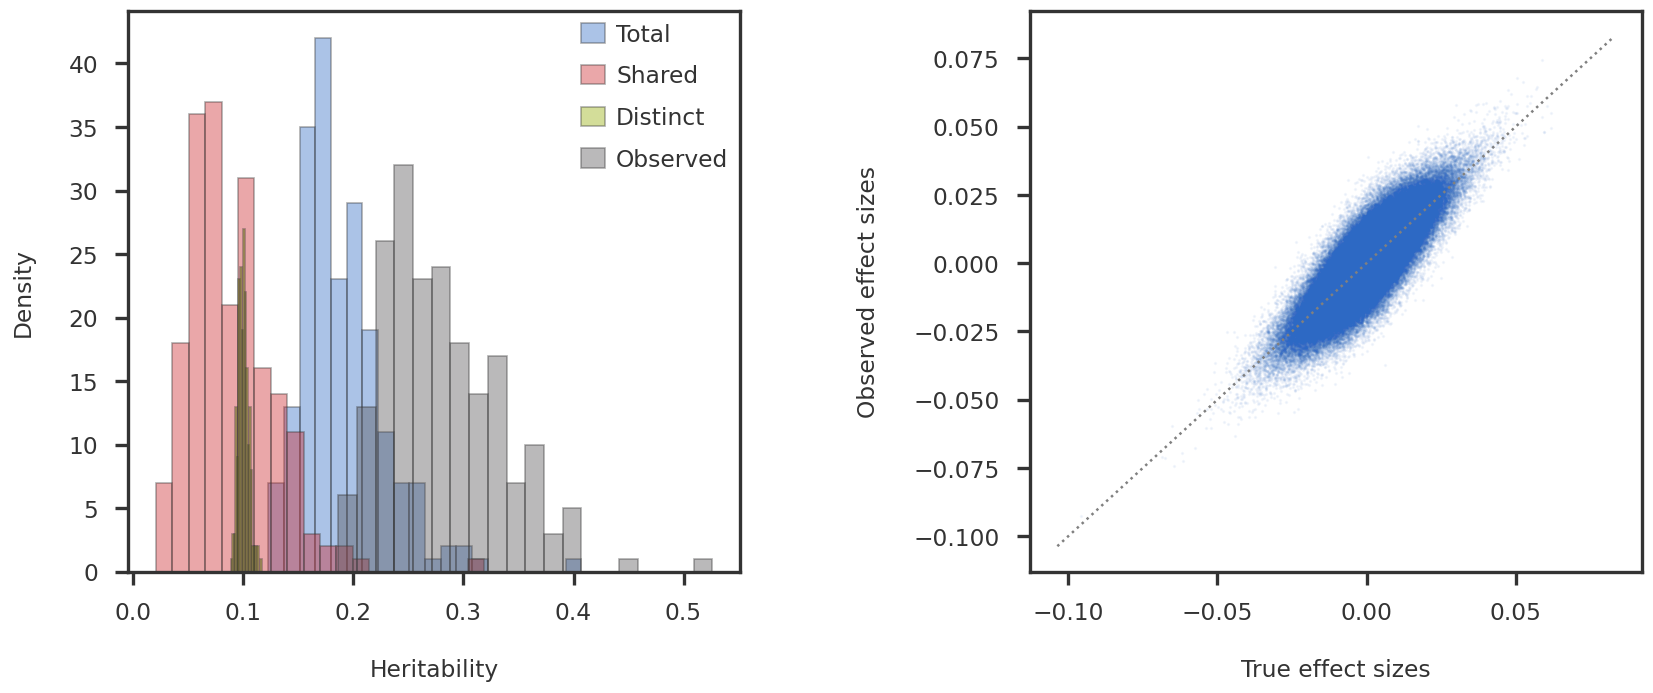

In [70]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

obs_hg2 = np.sum(np.square(Btrue), axis = 1)
obs_hg2_lf = np.sum(np.square(Btrue - M), axis = 1)
obs_hg2_m  = np.sum(np.square(M), axis = 1)
obs_hg2_noise = np.sum(np.square(B), axis = 1)

for hval, label in zip([obs_hg2, obs_hg2_lf, obs_hg2_m, obs_hg2_noise], ["Total", "Shared", "Distinct", "Observed"]):
    #xmin, xmax, bins, xbin = get_bins(obs_hg2, 100, 1e-8, 1.0)
    #curve = get_density(xbin, hval)
    #ax1.plot(xbin, curve, label = label)
    ax1.hist(hval, label = label, alpha = 0.4)
    
ax1.set_ylabel("Density")
ax1.set_xlabel("Heritability")
ax1.legend()

ax2.scatter(Btrue.ravel(), B.ravel(), s = 1, alpha = 0.05)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True effect sizes")
ax2.set_ylabel("Observed effect sizes")

plt.tight_layout(w_pad = 5)
plt.show()

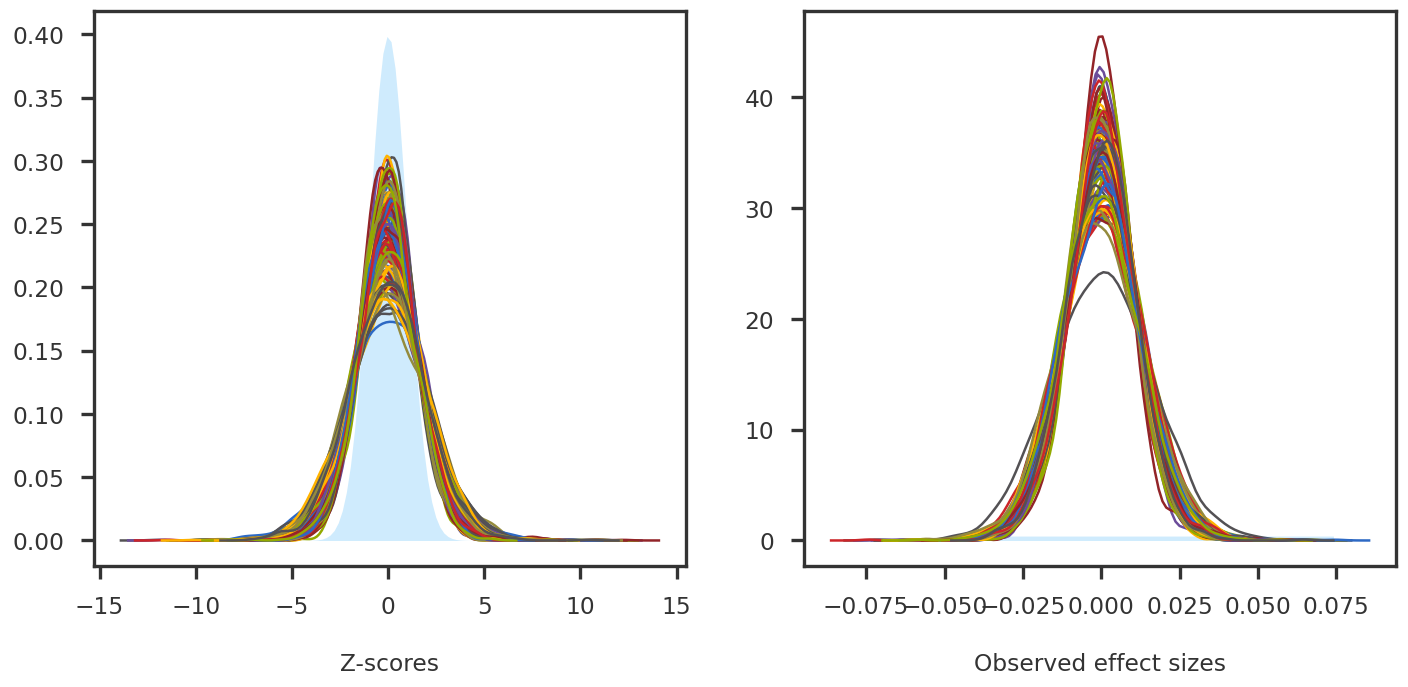

In [71]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Z_cent = Z - np.mean(Z, axis = 0, keepdims = True)

for i in range(100):
    scores_cent = Z_cent[i, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, None, None)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)
    
ax1.fill_between(xbin, spstats.norm.pdf(xbin, 0, 1.), lw = 0, color = 'lightskyblue', alpha = 0.4)
ax1.set_xlabel("Z-scores")

for i in range(100):
    scores_cent = B[i, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, None, None)
    curve = get_density(xbin, scores_cent)
    ax2.plot(xbin, curve)
    
ax2.fill_between(xbin, spstats.norm.pdf(xbin, 0, 1.), lw = 0, color = 'lightskyblue', alpha = 0.4)
ax2.set_xlabel("Observed effect sizes")
plt.show()

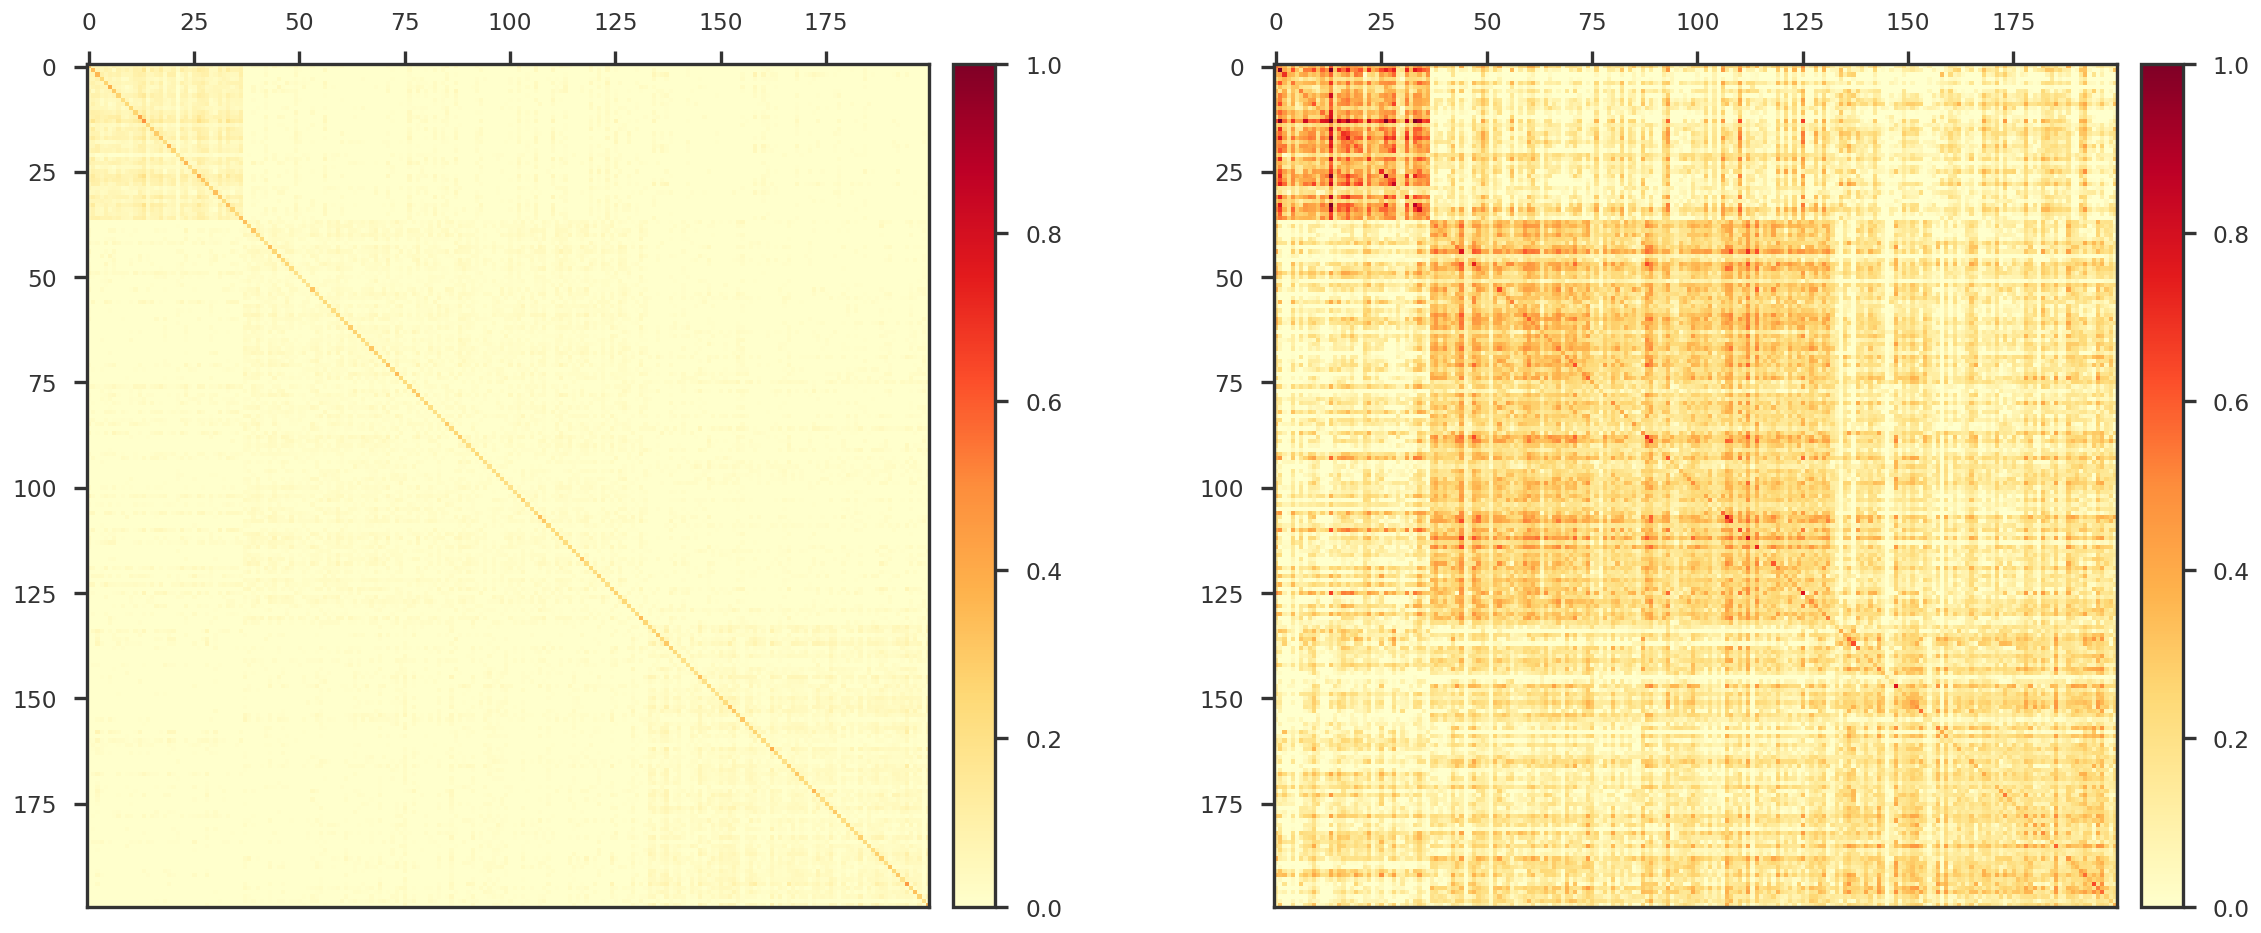

In [72]:
fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sorted_idx = np.concatenate([np.where(C == i)[0] for i in np.unique(C)])
mpy_plotfn.plot_covariance_heatmap(ax1, Z_cent[sorted_idx, :] * np.sqrt(p) / np.sqrt(nsample[sorted_idx]).reshape(n, 1))
#mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(p) / np.sqrt(nsample).reshape(n, 1))

mpy_plotfn.plot_covariance_heatmap(ax2, L[sorted_idx, :] * np.sqrt(k) / np.sqrt(np.min(h2)))

plt.tight_layout()
plt.show()

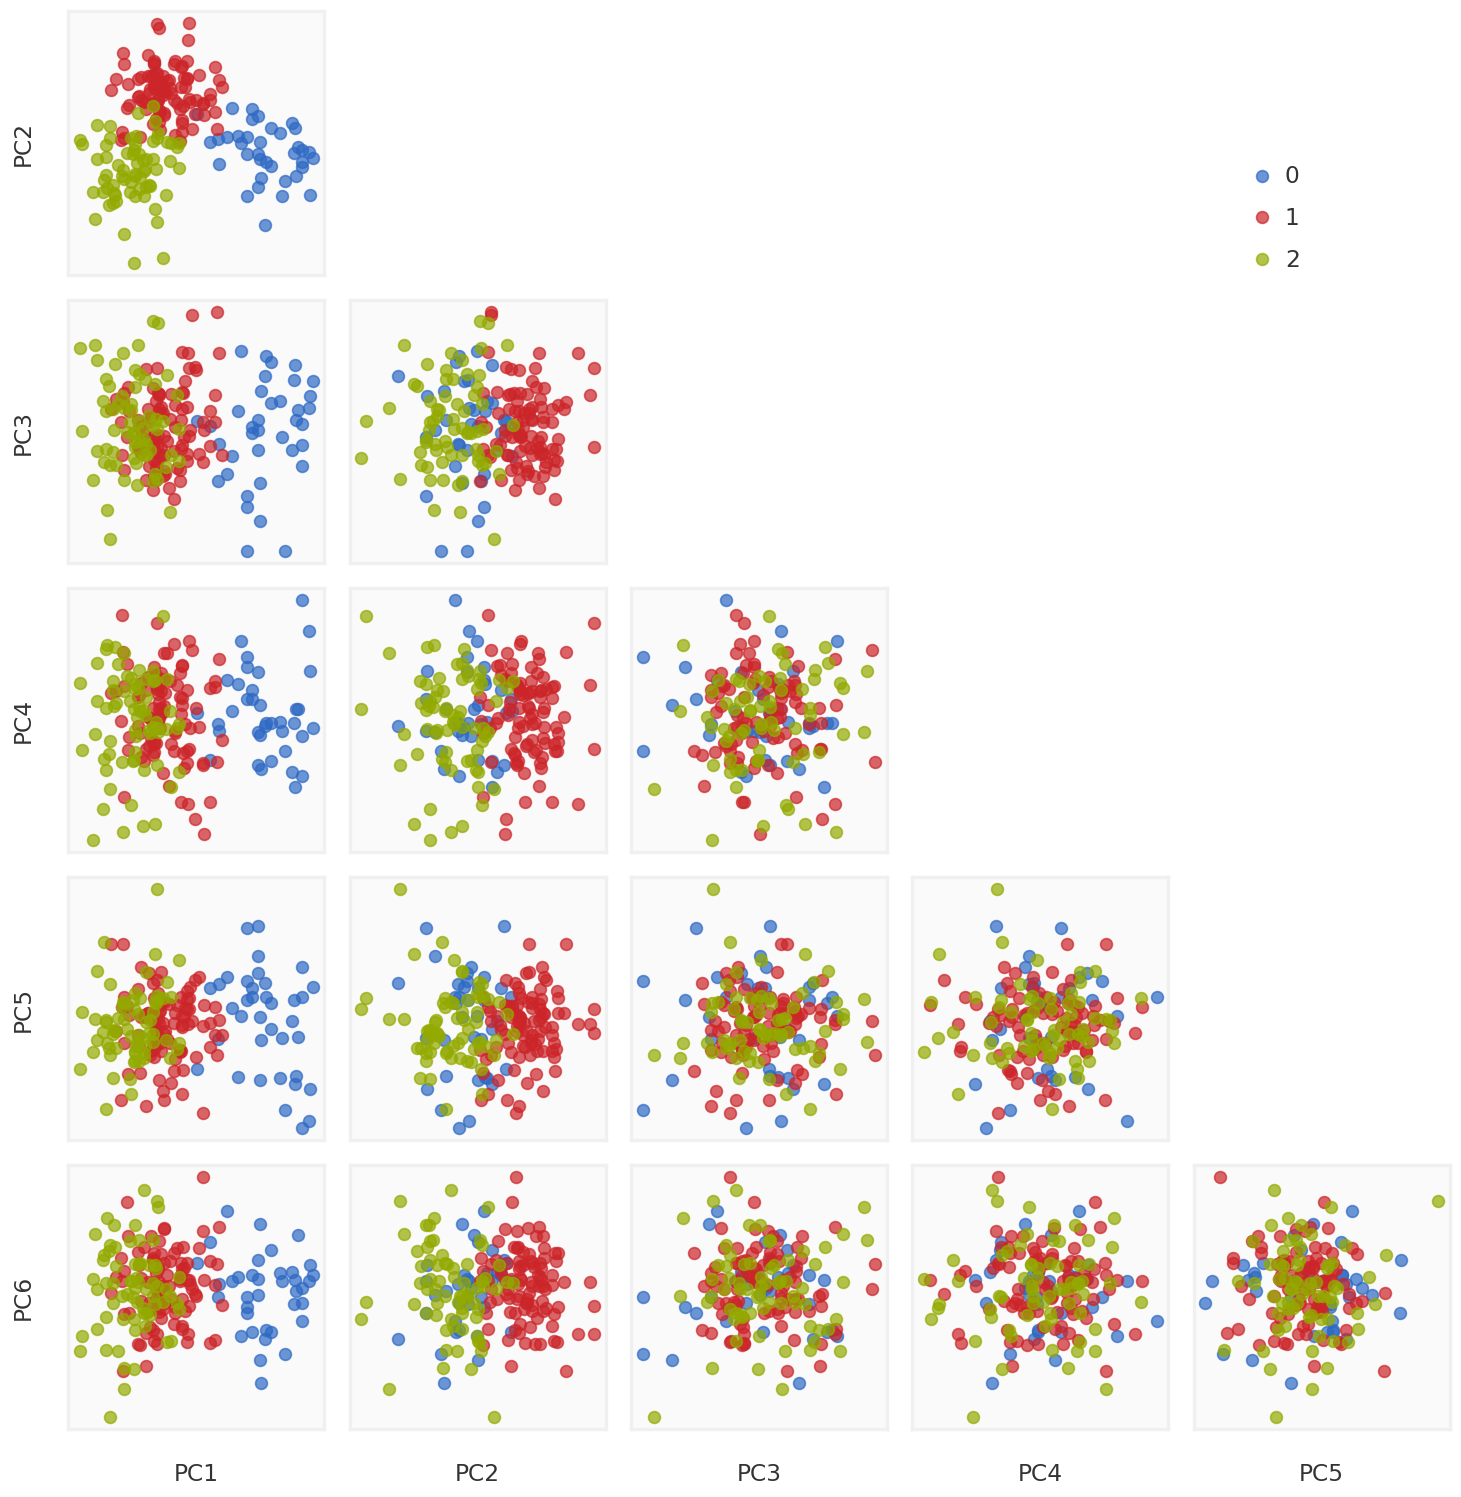

In [73]:
L_fit, F_fit, S2_fit = truncated_svd(Z_cent, 6)
axmain, axs = mpy_plotfn.plot_principal_components(L_fit , C, list(set(C)))
plt.show()

In [53]:
from nnwmf.optimize import IALM
rpca_model = IALM(max_iter = 10000, mu_update_method='admm', show_progress = True, print_skip = 100)
rpca_model.fit(Z_cent)

2024-01-27 12:52:51,057 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0224)
2024-01-27 12:52:51,240 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.900966. Dual residual 0.0010057
2024-01-27 12:52:59,110 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 3.86681e-06. Dual residual 1.23396e-06


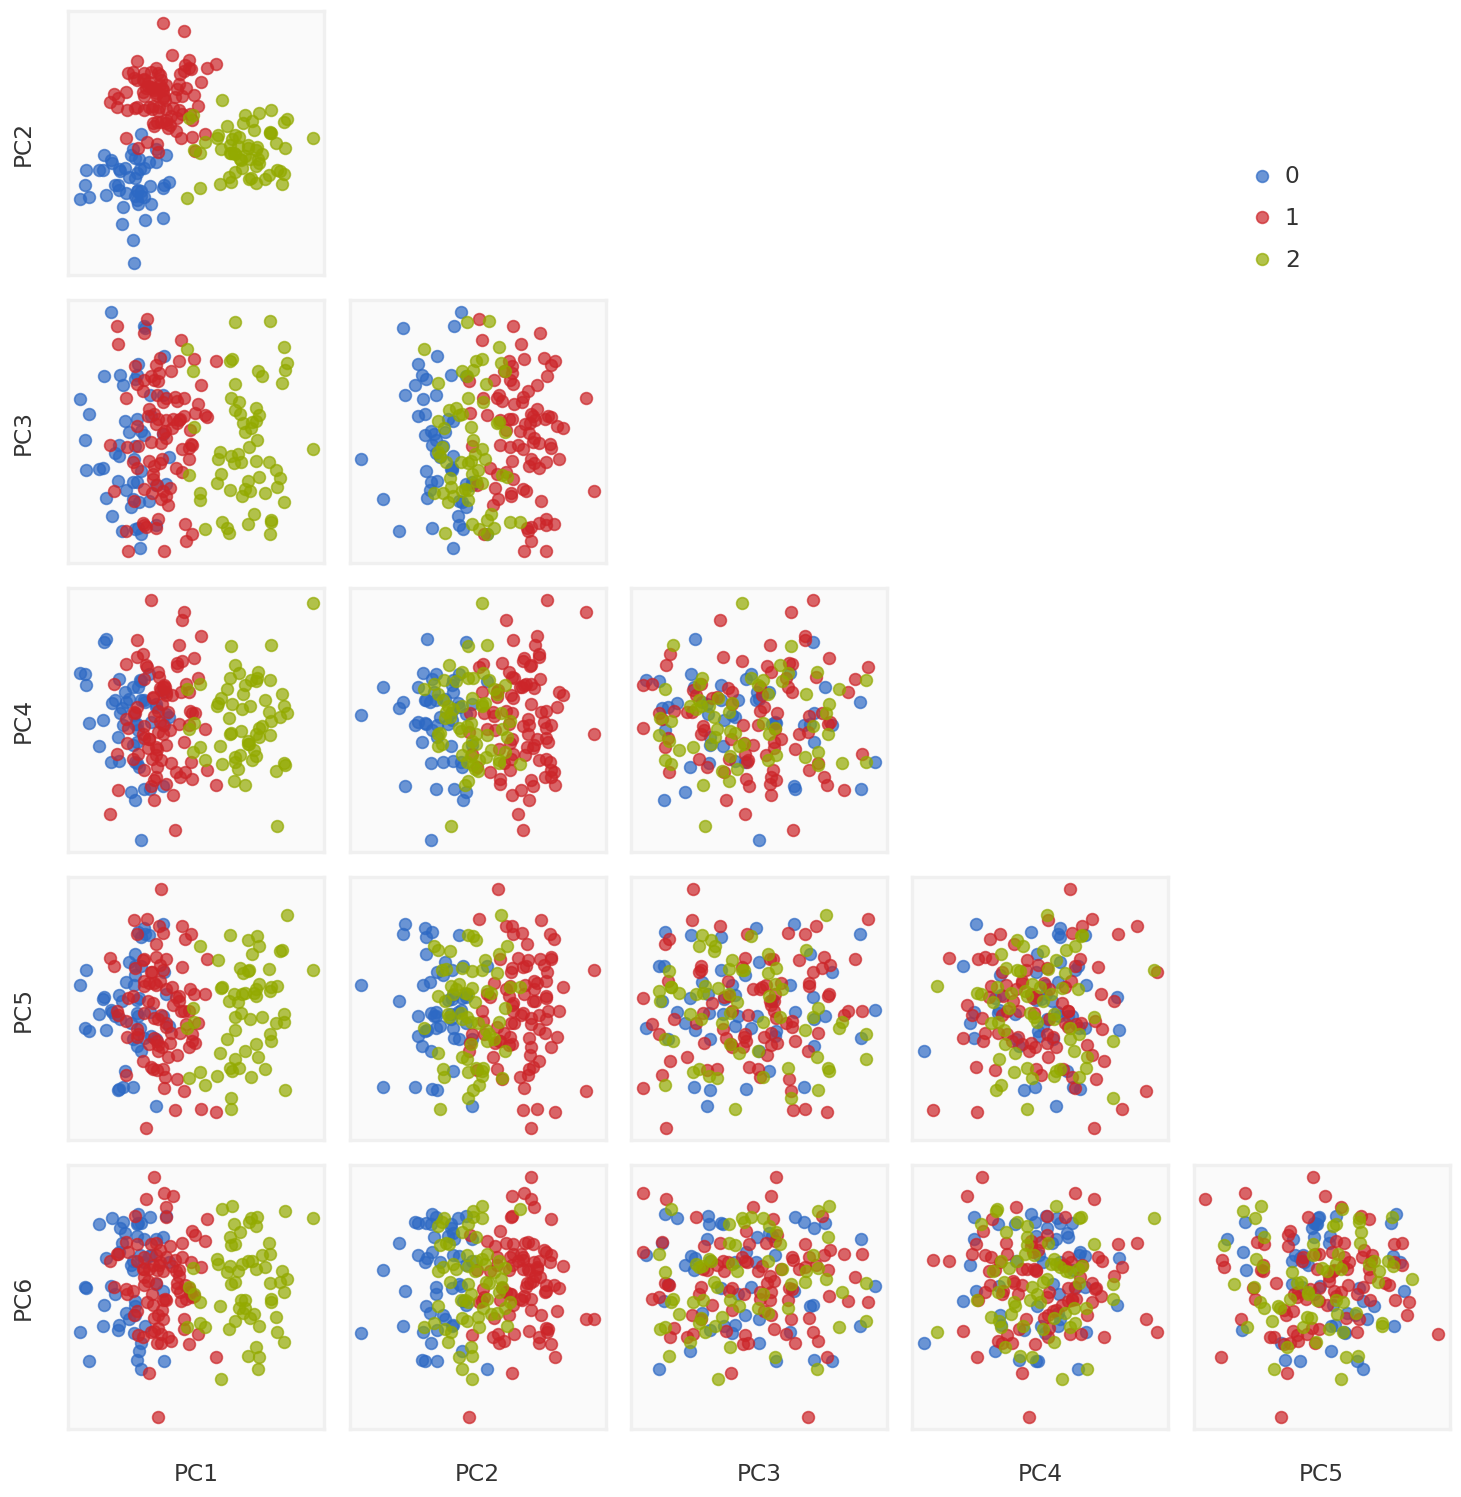

In [54]:
L_rpca, F_rpca, S2_rpca = truncated_svd(rpca_model.L_, 6)
axmain, axs = mpy_plotfn.plot_principal_components(L_rpca, C, list(set(C)))
plt.show()

In [55]:
fgo_model = FactorGoCLI()
fgo_model.fit(Z_cent, 6, nsample = nsample)

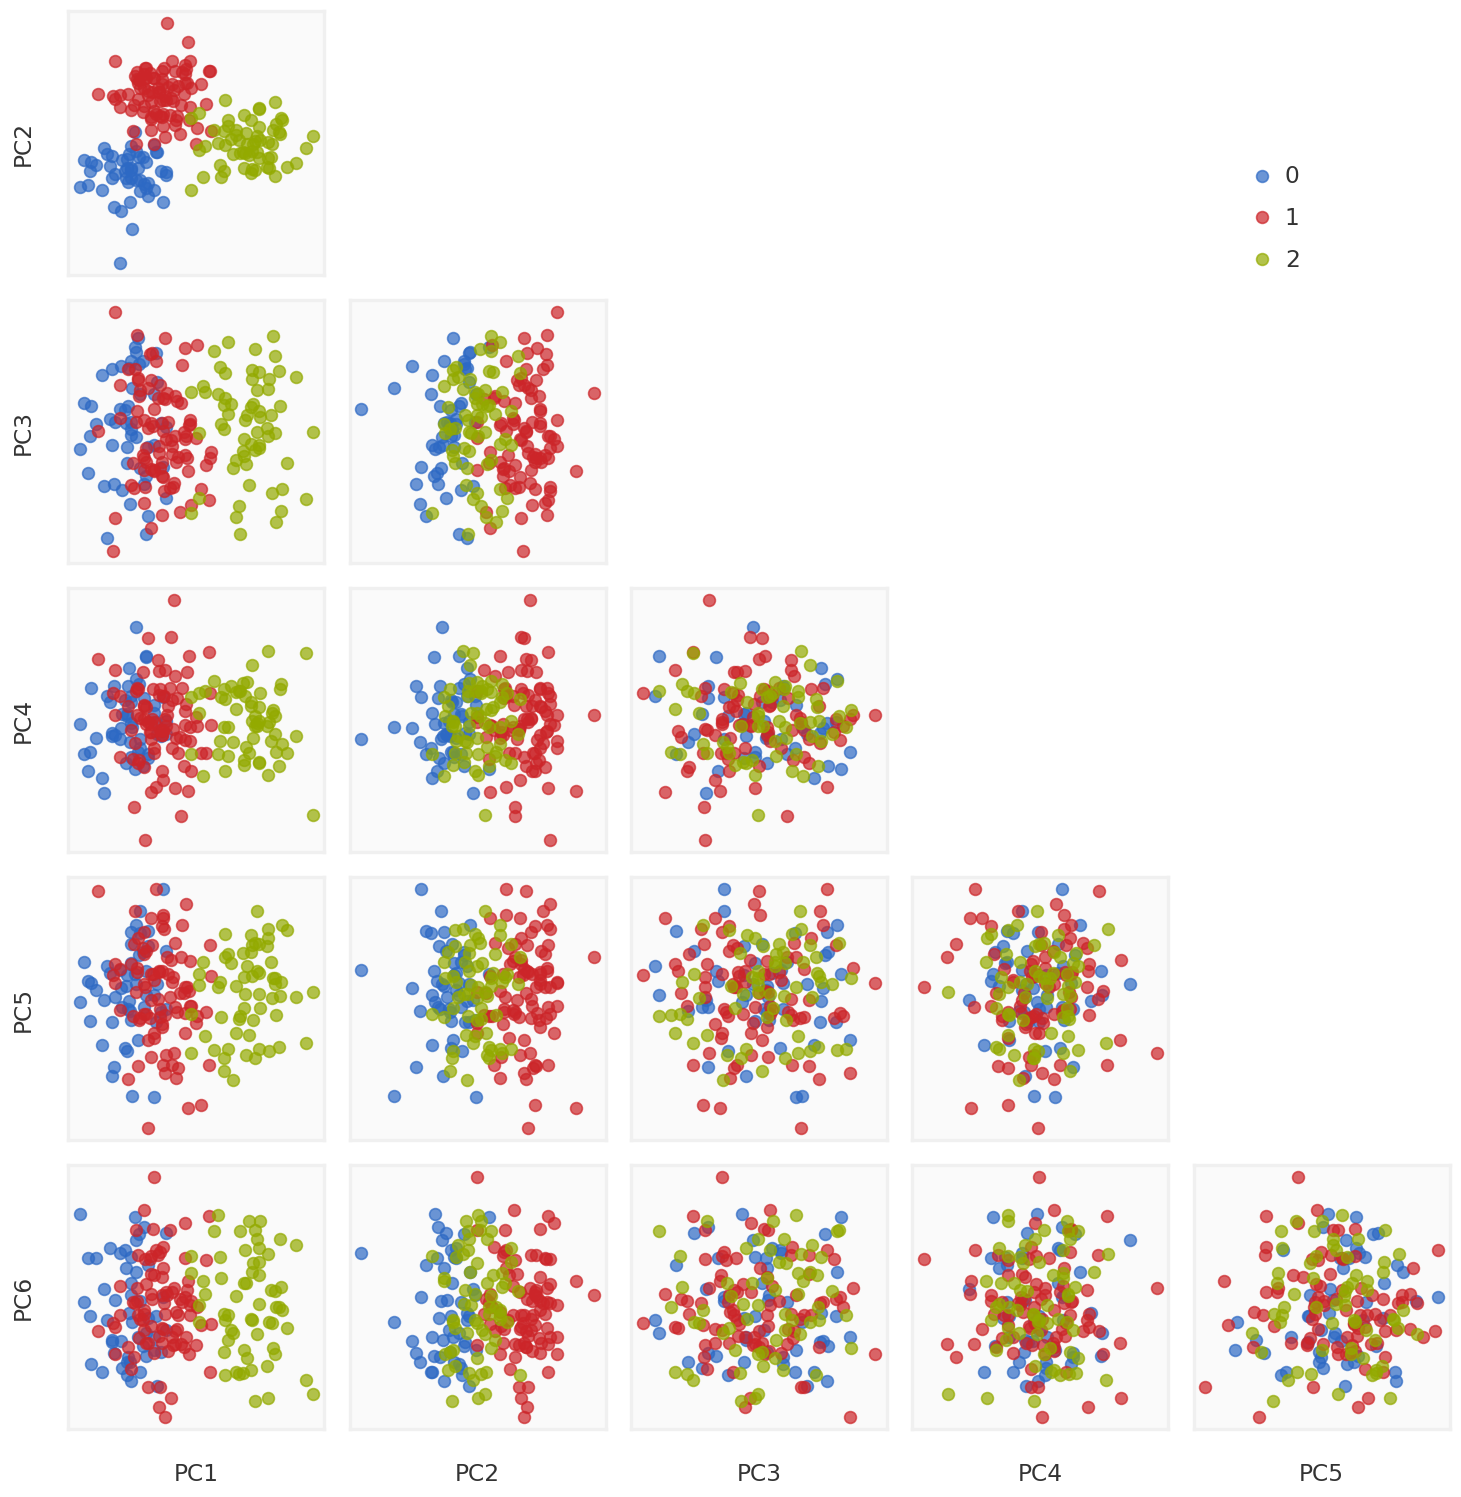

In [56]:
axmain, axs = mpy_plotfn.plot_principal_components(fgo_model.Zm, C, list(set(C)))
plt.show()

In [64]:
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
nnm_sparse_model = FrankWolfe(model = 'nnm-sparse', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm_sparse_model.fit(Z_cent, (50, 1.0))

2024-01-27 12:54:16,857 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 11473.2
2024-01-27 12:54:17,025 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:17,389 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:17,564 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:17,725 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:17,876 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:18,198 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-27 12:54:18,369 | nnwmf.optimize.frankwolfe                | WARN

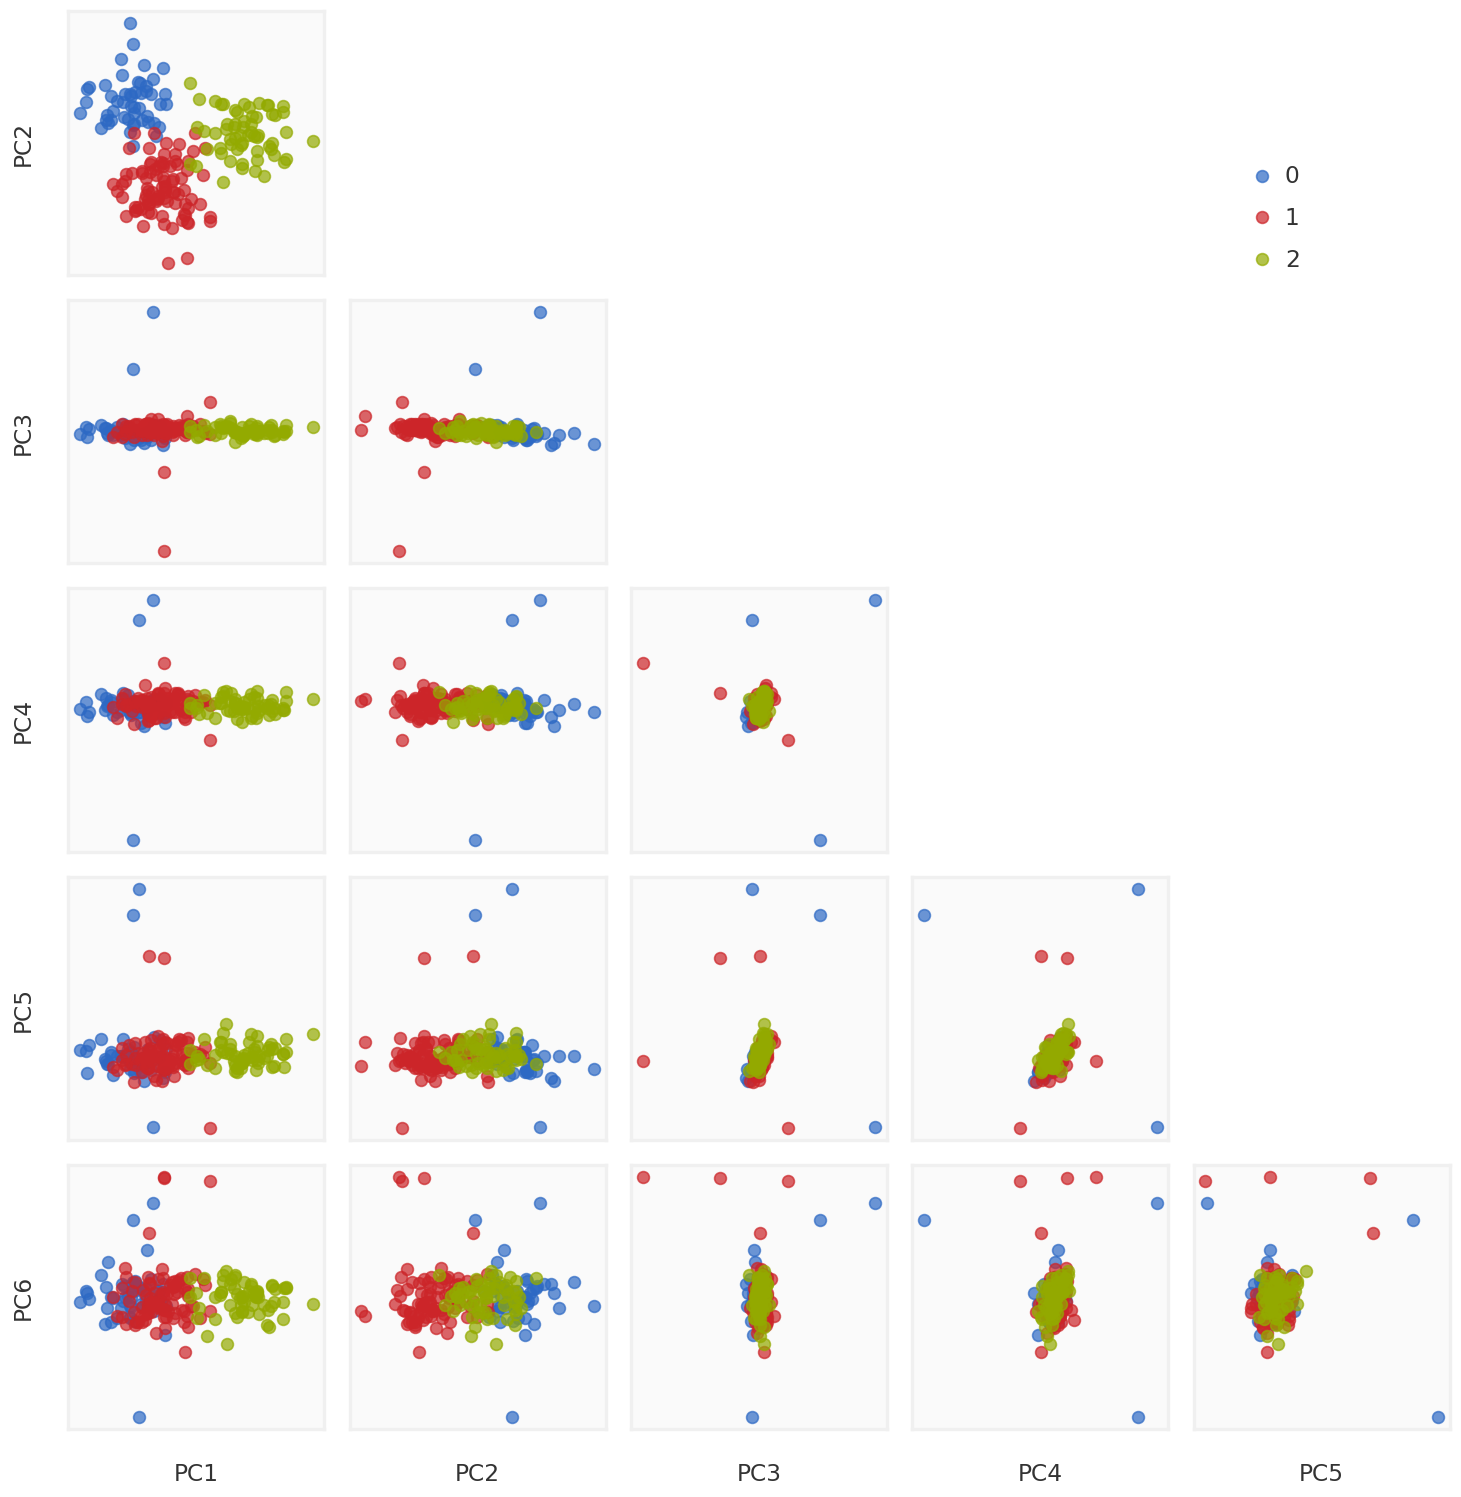

In [65]:
L_nnmsp, F_nnmsp, S2_nnmsp = truncated_svd(nnm_sparse_model.X, 6)
axmain, axs = mpy_plotfn.plot_principal_components(L_nnmsp, C, list(set(C)))
plt.show()

In [66]:
from scipy.spatial import procrustes

def mean_squared_error(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return mse


def peak_signal_to_noise_ratio(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    omax = np.max(original[mask == 1])
    omin = np.min(original[mask == 1])
    maxsig2 = np.square(omax - omin)
    mse = mean_squared_error(original, recovered, mask)
    res = 10 * np.log10(maxsig2 / mse)
    return res


def matrix_dissimilarity_scores(original, recovered, mask = None):
    '''
    Procrustes analysis returns the square of the Frobenius norm.
    Use the rotated matrix to obtain the peak signal-to-noise ratio (PSNR).
    '''
    k = min(original.shape[1], recovered.shape[1])
    R_orig, R_recv, m2 = procrustes(original[:, 0:k], recovered[:, 0:k])
    psnr = peak_signal_to_noise_ratio(R_orig, R_recv, mask)
    rmse = np.sqrt(mean_squared_error(R_orig, R_recv, mask))
    return rmse, psnr

orig_rmse, orig_psnr = matrix_dissimilarity_scores(L, L)
rpca_rmse, rpca_psnr = matrix_dissimilarity_scores(L, L_rpca)
tsvd_rmse, tsvd_psnr = matrix_dissimilarity_scores(L, L_fit)
fgo_rmse, fgo_psnr = matrix_dissimilarity_scores(L, fgo_model.Zm)
#nnm_rmse, nnm_psnr = matrix_dissimilarity_scores(L, L_fit)
nnm_sparse_rmse, nnm_sparse_psnr = matrix_dissimilarity_scores(L, nnm_sparse_model.X)

print (f"Original: {orig_rmse:g}")
print (f"RPCA: {rpca_rmse:g}")
print (f"tSVD: {tsvd_rmse:g}")
print (f"FactorGo: {fgo_rmse:g}")
#print (f"NNM: {nnm_rmse:g}")
print (f"NNM-Sparse: {nnm_sparse_rmse:g}")

Original: 2.55679e-17
RPCA: 0.015626
tSVD: 0.0162615
FactorGo: 0.0183724
NNM-Sparse: 0.0182648


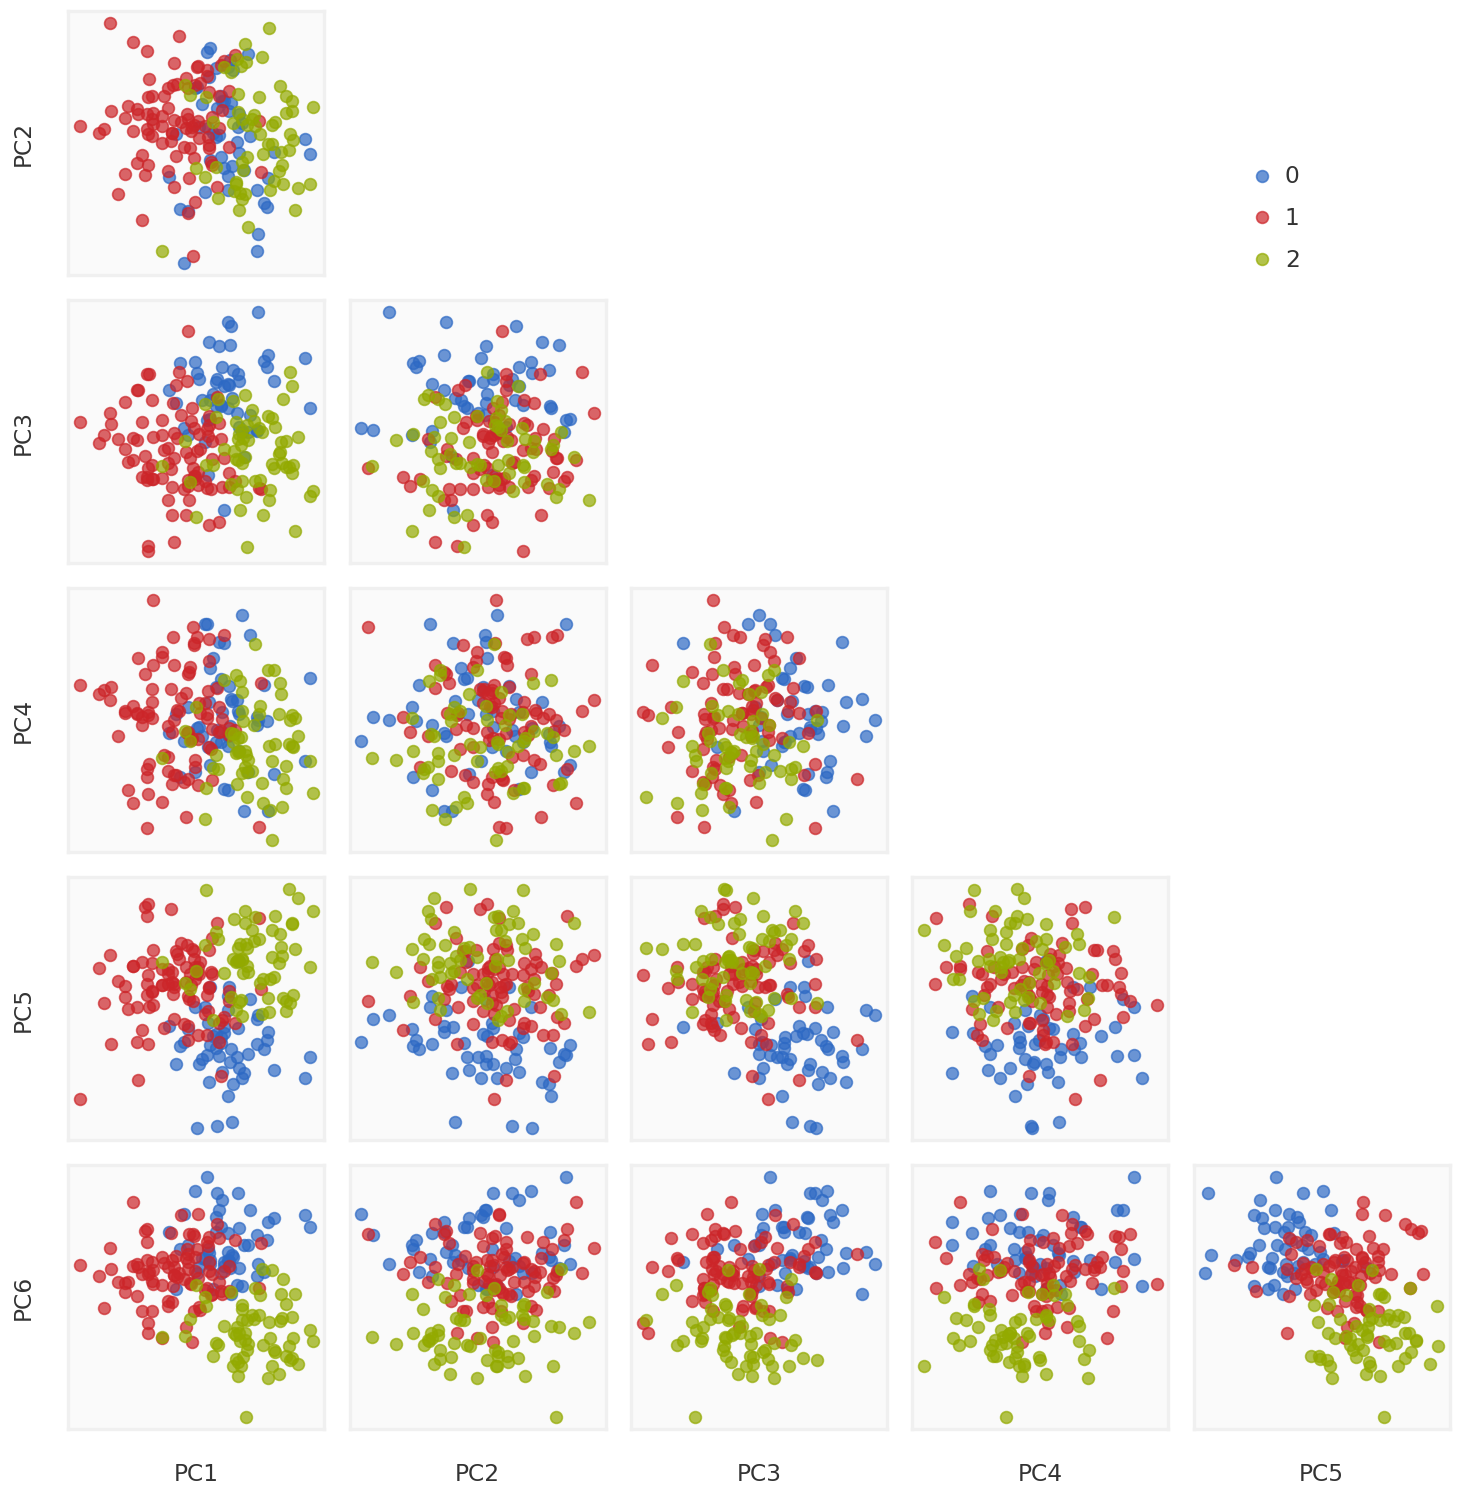

In [60]:
#L_fit, F_fit, S2_fit = truncated_svd(B - E, 20)
axmain, axs = mpy_plotfn.plot_principal_components(L , C, list(set(C)))
plt.show()

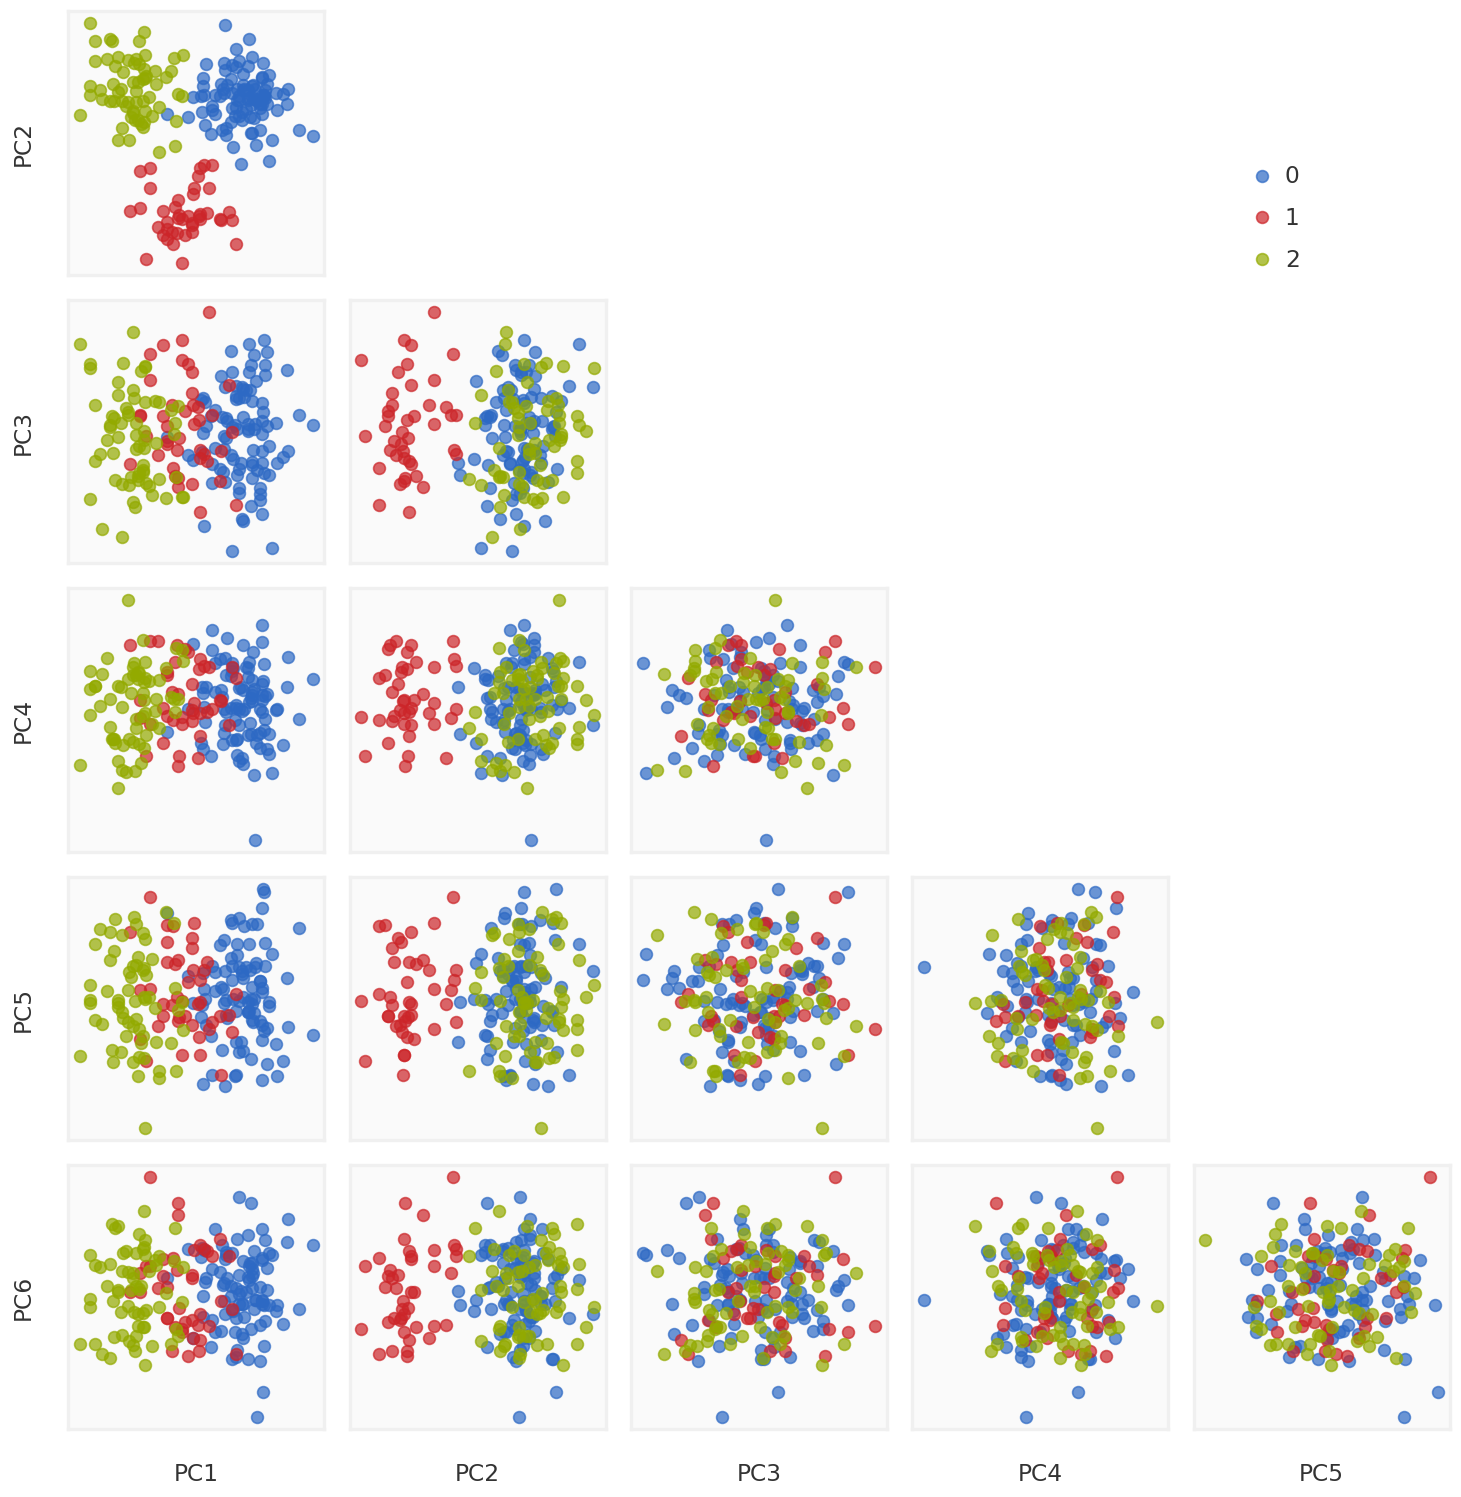

In [45]:
L_fit, F_fit, S2_fit = truncated_svd(L @ F.T, 20)
axmain, axs = mpy_plotfn.plot_principal_components(L_fit , C, list(set(C)))
plt.show()

In [76]:
user_k = [2, 5, 10, 15, 20]
L_est = {
    'tsvd': {i : None for i in user_k},
    'factorgo': {i : None for i in user_k}
}
F_est = {
    'tsvd': {i : None for i in user_k},
    'factorgo': {i : None for i in user_k}
}
S2_est = {
    'tsvd': {i : None for i in user_k},
    'factorgo': {i : None for i in user_k}
}

In [77]:
for i in user_k:
    print (i)
    L_tsvd, F_tsvd, S2_tsvd = truncated_svd(Z_cent, i)
    L_est['tsvd'][i] = L_tsvd
    F_est['tsvd'][i] = F_tsvd
    S2_est['tsvd'][i] = S2_tsvd
    fgo_model = FactorGoCLI()
    fgo_model.fit(Z_cent, i, nsample = nsample)
    L_est['factorgo'][i] = fgo_model.Zm
    F_est['factorgo'][i] = fgo_model.Wm
    S2_est['factorgo'][i] = fgo_model.variance_explained

2
5
10
15
20


In [112]:
def get_rmse_old(original, recovered, match = 'clip'):
    if match == 'clip':
        k = min(original.shape[1], recovered.shape[1])
        X = original[:, :k]
        Y = recovered[:, :k]
    elif match == 'zerofill':
        k = max(original.shape[1], recovered.shape[1])
        m = original.shape[0]
        X = np.zeros((m, k))
        Y = np.zeros((m, k))
        X[:, :original.shape[1]] = original
        Y[:, :recovered.shape[1]] = recovered
    R_orig, R_recv, m2 = procrustes(X, Y)
    return np.sqrt(m2)

def get_rmse(original, recovered, mask = None, match = 'zerofill'):
    ''' 
    Procrustes analysis returns the square of the Frobenius norm.
    Use the rotated matrix to obtain the peak signal-to-noise ratio (PSNR).
    Input matrices can have different dimensions.
    There are two ways to match:
        - clip: remove information from the larger matrix
        - zerofill: pad zero columns in the smaller matrix
    '''
    n_orig = original.shape[1]
    n_recv = recovered.shape[1]
    m = original.shape[0]
    if match == 'clip':
        n = min(n_orig, n_recv)
        X = original[:, :n] 
        Y = recovered[:, :n] 
    elif match == 'zerofill':
        n = max(n_orig, n_recv)
        X = np.zeros((m, n)) 
        Y = np.zeros((m, n)) 
        X[:, :n_orig] = original
        Y[:, :n_recv] = recovered
    R_orig, R_recv, m2 = procrustes(X, Y)
    psnr = peak_signal_to_noise_ratio(R_orig, R_recv, mask)
    return np.sqrt(m2), psnr

In [117]:
rmse_clip = {
    method: { i: get_rmse(L, L_est[method][i], match = 'clip')[1] for i in user_k } for method in ['tsvd', 'factorgo']
}

rmse_zerofill = {
    method: { i: get_rmse(L, L_est[method][i], match = 'zerofill')[1] for i in user_k } for method in ['tsvd', 'factorgo']
}

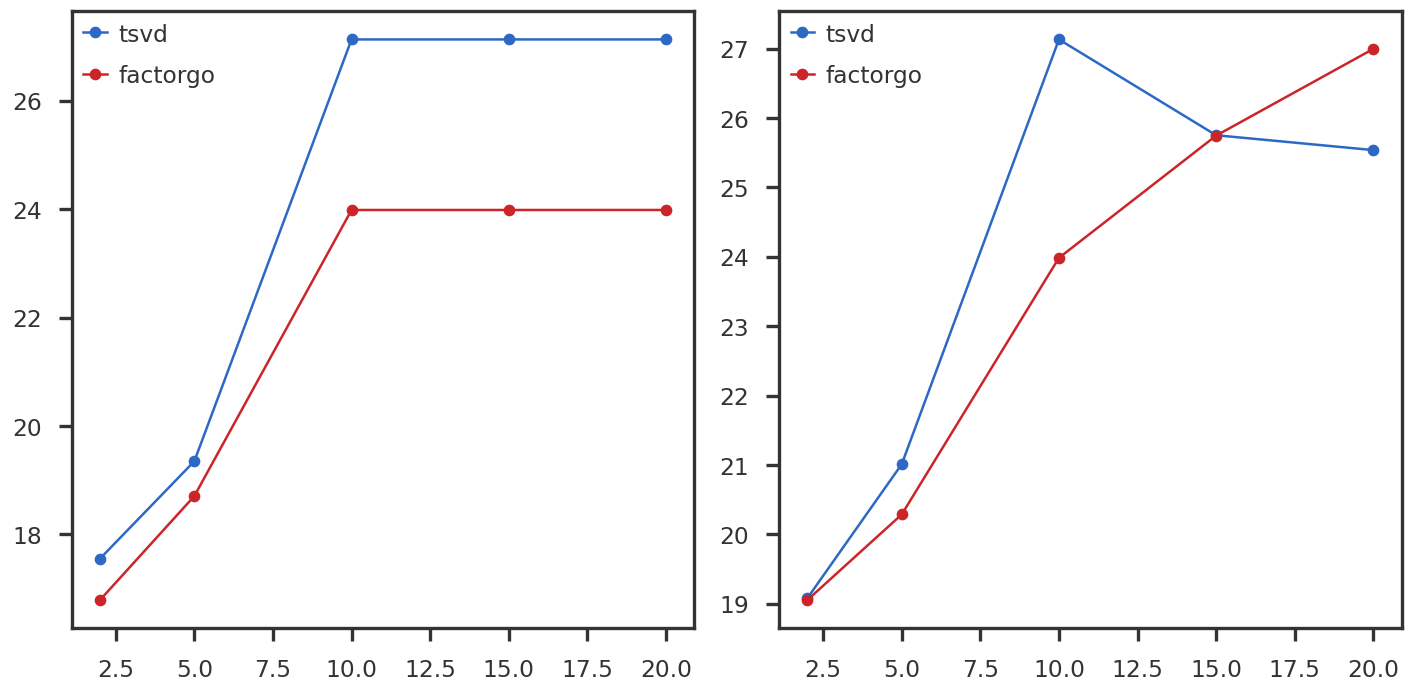

In [118]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for method in ['tsvd', 'factorgo']:
    yvals = [rmse_clip[method][i] for i in user_k]
    ax1.plot(user_k, yvals, marker = 'o', label = method)
ax1.legend()

for method in ['tsvd', 'factorgo']:
    yvals = [rmse_zerofill[method][i] for i in user_k]
    ax2.plot(user_k, yvals, marker = 'o', label = method)
ax2.legend()

plt.tight_layout()
plt.show()

In [119]:
S2_est

{'tsvd': {2: array([0.31514266, 0.14104323]),
  5: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348]),
  10: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ]),
  15: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ,
         0.02064236, 0.02044405, 0.02018368, 0.01975347, 0.01953347]),
  20: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ,
         0.02064236, 0.02044405, 0.02018368, 0.01975347, 0.01953347,
         0.01923938, 0.01899705, 0.01863417, 0.01846399, 0.01840355])},
 'factorgo': {2: array([0.10206661, 0.04529975]),
  5: array([0.10192078, 0.04530166, 0.02544522, 0.02426893, 0.02247066]),
  10: array([0.10188535, 0.0452901 , 0.02551659, 0.02430108, 0.02235207,
         0.02191148, 0.01849313, 0.01762496

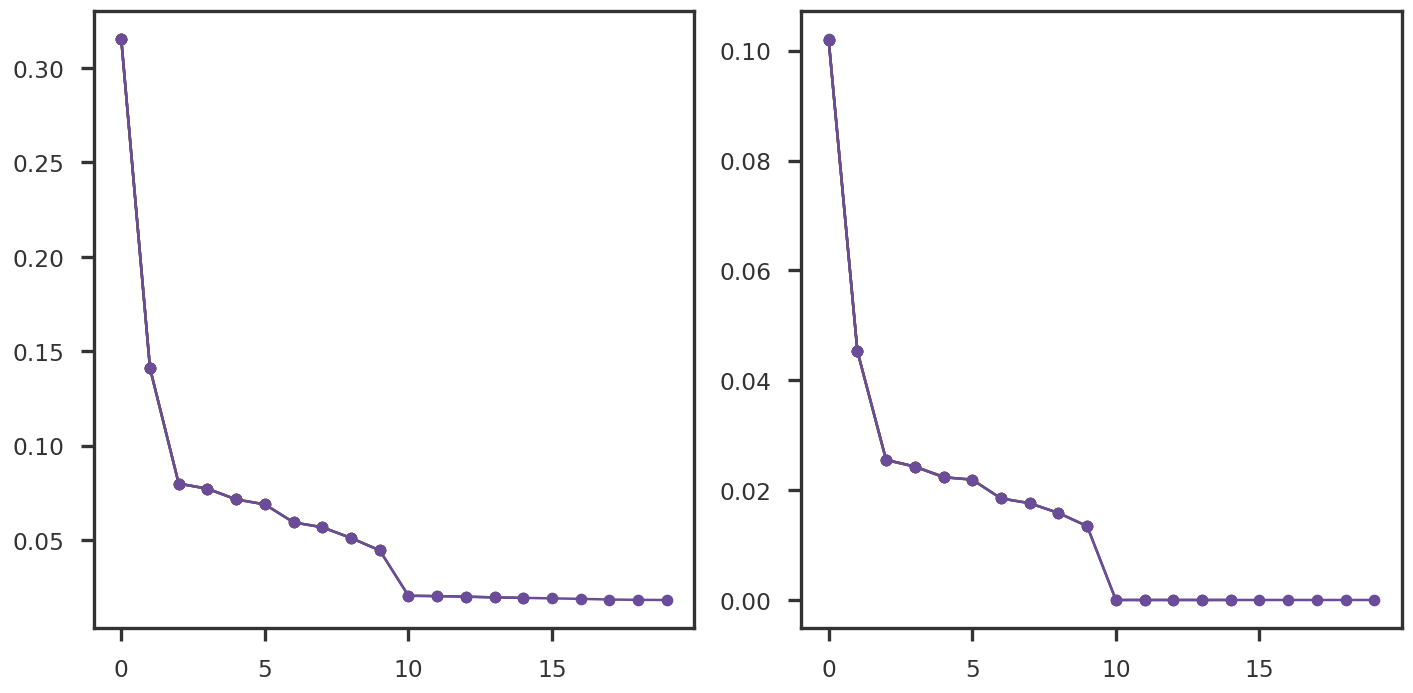

In [120]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in user_k:
    yvals = S2_est['tsvd'][i]
    ax1.plot(np.arange(i), yvals, marker = 'o')
    
for i in user_k:
    yvals = S2_est['factorgo'][i]
    ax2.plot(np.arange(i), yvals, marker = 'o')

plt.tight_layout()
plt.show()

In [109]:
S2_est

{'tsvd': {2: array([0.31514266, 0.14104323]),
  5: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348]),
  10: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ]),
  15: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ,
         0.02064236, 0.02044405, 0.02018368, 0.01975347, 0.01953347]),
  20: array([0.31514266, 0.14104323, 0.08001692, 0.07730253, 0.07164348,
         0.06900678, 0.0594717 , 0.05689453, 0.05122711, 0.044641  ,
         0.02064236, 0.02044405, 0.02018368, 0.01975347, 0.01953347,
         0.01923938, 0.01899705, 0.01863417, 0.01846399, 0.01840355])},
 'factorgo': {2: array([0.10206661, 0.04529975]),
  5: array([0.10192078, 0.04530166, 0.02544522, 0.02426893, 0.02247066]),
  10: array([0.10188535, 0.0452901 , 0.02551659, 0.02430108, 0.02235207,
         0.02191148, 0.01849313, 0.01762496

In [87]:
get_rmse(L, L_est['tsvd'][2], match = 'zerofill')

0.7198083772638655

In [ ]:
def get_mse(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n 
    return mse

def get_psnr(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    omax = np.max(original[mask == 1]) 
    omin = np.min(original[mask == 1]) 
    maxsig2 = np.square(omax - omin)
    mse = get_mse(original, recovered, mask)
    res = 10 * np.log10(maxsig2 / mse)
    return res

def matrix_dissimilarity_scores(original, recovered, mask = None):
    '''
    Procrustes analysis returns the square of the Frobenius norm.
    Use the rotated matrix to obtain the peak signal-to-noise ratio (PSNR).
    '''
    k = min(original.shape[1], recovered.shape[1])
    R_orig, R_recv, m2 = procrustes(original[:, 0:k], recovered[:, 0:k])
    psnr = get_psnr(R_orig, R_recv, mask)
    return np.sqrt(m2), psnr